In [1]:
%load_ext autotime

# Examine Target

This notebook look at some of the properties for a specific target as pulled from the sources listed generated in the [Source Detection](PIAA-Source-Detection-And-Filtering.ipynb) notebook. 

Note that this step is not necessary for the processing of an observation sequence as a whole but instead serves to highlight some of the issues with processing the images in a traditional fashion and thus helps motivate our unique algorithm.

In [2]:
import os
from contextlib import suppress

from matplotlib import cm
from matplotlib import pyplot as plt
plt.style.use('bmh')

import numpy as np
import pandas as pd
from collections import defaultdict

from tqdm import tqdm_notebook as tqdm

from piaa.utils import pipeline
from piaa.utils import helpers
from piaa.utils import plot
from piaa.utils.postgres import get_cursor
from piaa.utils import noise

from pocs.utils.images import fits as fits_utils
from pocs.utils.google.storage import PanStorage

from astropy.io import fits
from astropy.stats import sigma_clip
from astropy import units as u

tess_cursor = get_cursor(port=5433, db_name='v6', db_user='postgres')

styles = plot.get_labelled_style_cycler(cmap='Paired')

time: 6.7 s


## Specify Target

Here we look up the target HD189733 by the 2MASS ID.

In [3]:
# picid = 435715608
# picid = 287933433
# picid = 287511722
# picid = 393243342
# picid = 343362027 # Hot pixel?
# picid = 11133916  # Same mag as HD189733
# picid = 86234511
# picid = helpers.get_star_info(twomass_id='20005694+2250490', cursor=tess_cursor).id
# picid = 11135315

picid = 417898196

star_info = helpers.get_star_info(picid=picid, cursor=tess_cursor)

time: 91.5 ms


In [4]:
# twomass = '20004370+2242391'

# star_info = helpers.get_star_info(twomass_id=twomass, cursor=tess_cursor)
# picid = star_info.id  # HD 189733

time: 2.39 ms


In [5]:
print(f'PICID: {picid}')

PICID: 417898196
time: 3.03 ms


#### Observation sources

We use the previously detected and filtered sources to examine our target. See the [Source-Detection](Source-Detection-And-Filtering.ipynb) for details.

In [6]:
base_dir = '/var/panoptes/images/fields/PAN012/358d0f/20180822T035809/'
# base_dir = '/var/panoptes/images/fields/PAN001/Hd189733/14d3bd/20180913T085704/'
source_filename = os.path.join(base_dir, f'point-sources-filtered.csv')

time: 3.11 ms


In [7]:
sources = pipeline.lookup_sources_for_observation(filename=source_filename)
source_phot = pd.read_csv(os.path.join(base_dir, f'point-sources-noise.csv')).set_index(['date_obs'])
source_phot.index = pd.to_datetime(source_phot.index)

target_table = sources.loc[sources.picid == picid].copy()
target_phot = source_phot.loc[source_phot.picid == picid].copy()

time: 3.39 s


For our target table we want to compare the flux as calculated from `sextractor` (which has no knowledge of the RGB array) with that pulled from a custom stamp.  `sextractor` uses a 6-pixel circular aperture  centered around the calculated centroid (the `x` and `y` values in our `sources` table) while our custom stamps will use an aperture that is sliced according to our rule of having a fixed pixel pattern. Here we use a 6-pixel aperture on our stamps for direct comparison with `sextractor` but the size can be vary.

In [8]:
camera_bias = 2048 * u.adu
stamp_size = 6 * u.pixel
num_pixels = (stamp_size**2).value

readout_noise = 10.5 * u.electron / u.pixel
gain = 1.5 * (u.electron / u.adu)
qe = 0.43

focal_length = 85 * u.mm
fstop = 1.4

aperture_area = focal_length / fstop
aperture_area = (np.pi * (aperture_area / 2)**2).to(u.m * u.m)

time: 11.3 ms


In [9]:
for date_obs, row in tqdm(target_table.iterrows(), total=len(target_table)):
    
    # Get the data for the entire frame
    data = fits.getdata(os.path.join(base_dir, row.file)) 
    
    # Get the stamp for the target
    target_slice = helpers.get_stamp_slice(row.x, row.y, stamp_size=(stamp_size.value, stamp_size.value), ignore_superpixel=False)
    
    # Get data and remove the bias
    stamp = data[target_slice] - row.background # camera_bias.value
    
    flux_stamp = stamp.sum()
    target_table.loc[date_obs, 'flux_stamp'] = flux_stamp
    target_table.loc[date_obs, 'photnoise_stamp'] = np.sqrt(stamp.sum()) / flux_stamp
    
    color_data = helpers.get_rgb_data(stamp, force_new=True)
    
    # Calculate some properties for each channel
    for color, data in zip('rgb', color_data):
        # Total sum of stamp
        target_table.loc[date_obs, f'flux_{color}'] = int(data.sum())
        
        # Photon noise (includes background)
        try:
            phot_noise = int(np.sqrt(data.sum()))
        except ValueError:
            phot_noise = np.nan
        target_table.loc[date_obs, f'photon_noise_stamp_{color}'] = phot_noise
        
        # Readout noise
        target_table.loc[date_obs, f'readout_stamp_{color}'] = int(((readout_noise / gain) * (data.count() * u.pixel)).value) #/ flux_stamp

/home/wtylergee/miniconda3/envs/pipeline/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in sqrt



time: 1min 2s


In [10]:
# Save target table
target_table.to_csv(os.path.join(os.path.join(base_dir, f'target-table-{picid}.csv')))

time: 12.2 ms


In [11]:
target_table.head()

,ra,dec,x,y,xpeak_image,ypeak_image,background,flux_best,fluxerr_best,mag_best,...,photnoise_stamp,flux_r,photon_noise_stamp_r,readout_stamp_r,flux_g,photon_noise_stamp_g,readout_stamp_g,flux_b,photon_noise_stamp_b,readout_stamp_b
obs_time,,,,,,,,,,,,,,,,,,,,,
2018-08-22 04:02:02,298.866948,20.275521,3055,1801,3054.9333,1800.8268,3598.571,11912.62,2186.640,14.8100,...,0.009497,8815.0,93.0,63.0,-2803.0,NaN,126.0,5073.0,71.0,63.0
2018-08-22 04:07:23,298.867033,20.276343,3056,1802,3055.4390,1802.1014,3636.088,10779.39,1374.445,14.9185,...,0.010495,7390.0,85.0,63.0,-3471.0,NaN,126.0,5160.0,71.0,63.0
2018-08-22 04:09:11,298.866688,20.276501,3055,1802,3055.1716,1802.2853,3630.643,10481.51,1419.958,14.9489,...,0.010191,-1681.0,NaN,63.0,12723.0,112.0,126.0,-1412.0,NaN,63.0
2018-08-22 04:10:58,298.866848,20.276215,3055,1802,3055.2351,1802.3123,3620.287,10302.07,1550.129,14.9677,...,0.010082,-1687.0,NaN,63.0,12913.0,113.0,126.0,-1388.0,NaN,63.0
2018-08-22 04:12:46,298.866985,20.275532,3055,1801,3054.9478,1800.5416,3514.677,13554.13,1737.392,14.6698,...,0.009081,8285.0,91.0,63.0,-1821.0,NaN,126.0,5662.0,75.0,63.0


time: 47.1 ms


#### Time-binned 

In addition to our raw data we want to bin the data according to time for the various flux measurements. The default is a 20 minute time bin and the values are averaged over that bin. Note that binning on time means there can be an uneven number of frames per bin.

Binning the data over time will smooth the scatter that's seen due to the periodic error (see below).

In [12]:
bin_minutes = 15

target_bin = target_table.resample(f'{bin_minutes}T').mean()

time: 22.5 ms


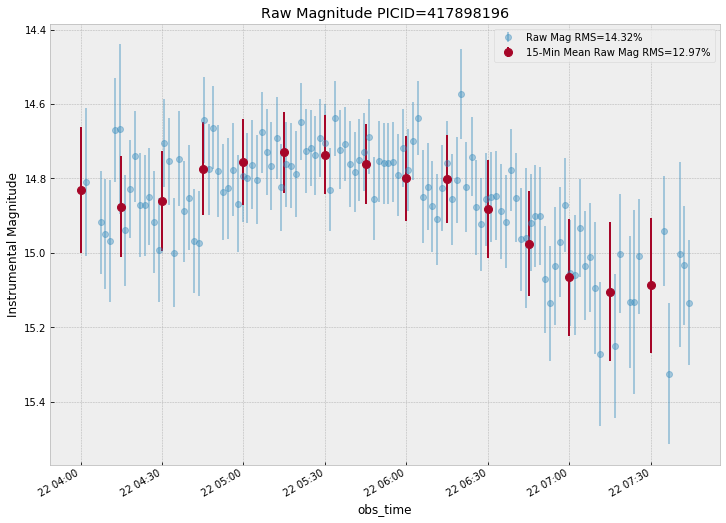

time: 583 ms


In [13]:
plt.figure(figsize=(12, 9))
target_table.mag_best.plot(ls='', marker='o', yerr=target_table.magerr_best, alpha=0.4, label=f'Raw Mag RMS={target_table.mag_best.std():.02%}')

target_bin.mag_best.plot(
                        ls='', marker='o', ms=8, 
                        yerr=target_bin.magerr_best, 
                        label=f'{bin_minutes}-Min Mean Raw Mag RMS={target_bin.mag_best.std():.02%}')

plt.title(f'Raw Magnitude PICID={picid}')
plt.ylabel('Instrumental Magnitude')
plt.gca().invert_yaxis()
plt.legend()
plt.show()

#### Basic Aperture Photometry - sextractor

We can look at the basic aperture photometry using the instrumental magintude as it comes out of `sextractor`. A 6 pixel aperture is used and the local background is subtracted. Instrumental magnitudes are calculated with a zeropoint offset of 25.

Here we show the raw instrumental magnitudes as well as the magnitude averaged across a 20 minute time bin.

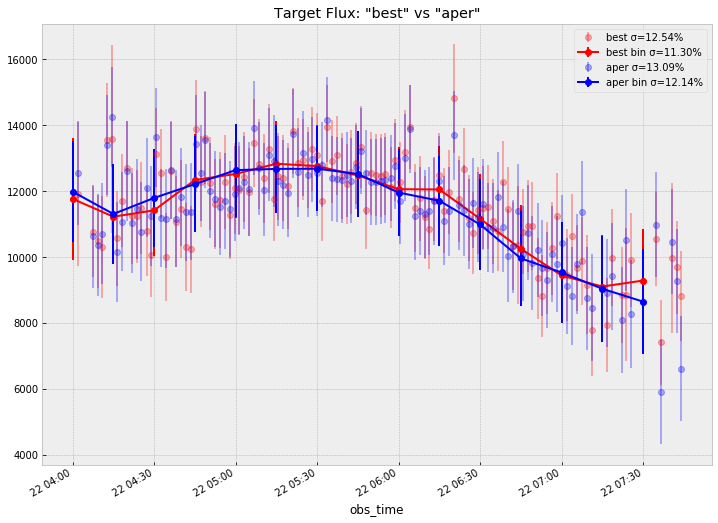

time: 664 ms


In [14]:
plt.figure(figsize=(12, 9))
std0 = target_bin.flux_best.std() / target_bin.flux_best.mean()
std1 = target_table.flux_best.std() / target_table.flux_best.mean()
target_table.flux_best.plot(yerr=target_table.fluxerr_best, ls='', marker='o', alpha=0.3, label=f'best σ={std1:.02%}', c='r')
target_bin.flux_best.plot(yerr=target_bin.fluxerr_best, ls='-', marker='o', label=f'best bin σ={std0:.02%}', c='r')

std2 = target_bin.flux_aper.std() / target_bin.flux_aper.mean()
std3 = target_table.flux_aper.std() / target_table.flux_aper.mean()
target_table.flux_aper.plot(yerr=target_table.fluxerr_aper, ls='', marker='o', alpha=0.3,  label=f'aper σ={std3:.02%}', c='b')
target_bin.flux_aper.plot(yerr=target_bin.fluxerr_aper, ls='-', marker='o', label=f'aper bin σ={std2:.02%}', c='b')

plt.title('Target Flux: "best" vs "aper"')
plt.legend()

#### Differential photometry - sextractor

We can find some of the bright stars in the field and use them to correct for some of the major systematic effects that we are seeing in the light curve. We manually select three stars in the field and average them together and plot this versus our target instrumental magnitude.

In [15]:
# Get the bright stars
# bright_stars = sources.groupby('picid').snr.mean().sort_values(ascending=False).index.values[10:13]
# bright_stars = sources.groupby('picid').apply(lambda row: row['flux_best'].mean() / row['fluxerr_best'].mean()).sort_values().index.values[-5:]

# bright_stars = list(set(sources.loc[(sources.vmag == 7.67)].picid.values))
bright_stars = list(set(sources.loc[np.logical_and(sources.vmag >= target_table.iloc[0].vmag - 0.1, sources.vmag <= target_table.iloc[0].vmag + 0.1)].picid))[2:7]

with suppress(ValueError, AttributeError):
    bright_stars.remove(picid)

print(f'Found {len(bright_stars)} stars of similar magnitude')

bright_table = sources.loc[np.isin(sources.picid, bright_stars)].copy()
binned_bright = bright_table.groupby('picid').resample(f'{bin_minutes}T').mean()

Found 5 stars of similar magnitude
time: 35.5 ms


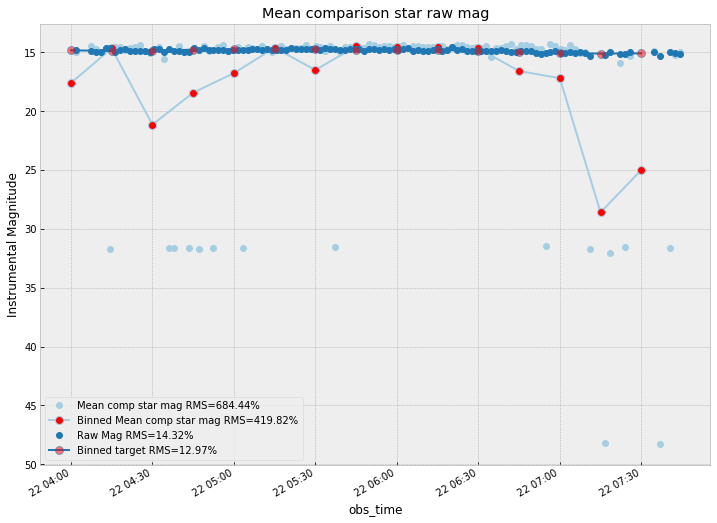

time: 547 ms


In [16]:
# Plot the comp stars mean
plt.figure(figsize=(12, 9))

comp_star = bright_table.groupby('obs_time').mean()
binned_comp_star = binned_bright.groupby('obs_time').mean()
comp_star.mag_best.plot(label=f'Mean comp star mag RMS={comp_star.mag_best.std():.02%}', ls='', marker='o', **styles['comp_star'])
binned_comp_star.mag_best.plot(label=f'Binned Mean comp star mag RMS={binned_comp_star.mag_best.std():.02%}', marker='o', markerfacecolor='r', ms=8, **styles['comp_star'])

# Plot target
target_table.mag_best.plot(label=f'Raw Mag RMS={target_table.mag_best.std():.02%}', ls='', marker='o', **styles[picid])
target_bin.mag_best.plot(label=f'Binned target RMS={target_bin.mag_best.std():.02%}', marker='o', markerfacecolor=(1,0,0,0.5), ms=8, **styles[picid])


plt.gca().invert_yaxis()
plt.ylabel('Instrumental Magnitude')
plt.title('Mean comparison star raw mag')
plt.legend()

This at least confirms that they have a somewhat similar shape, which is what we would expect if the large-scale variations were due to systematics that affect he frame as a whole.

In [17]:
target_phot.head()

,back,back_noise,channel,counts,dark_noise,noise,photon_noise,picid,readout_noise
date_obs,,,,,,,,,
2018-08-22 04:02:02,1563.454545,465.211438,all,3976.545455,200.0,509.039991,51.488157,417898196,700.0
2018-08-22 04:02:02,1211.818182,71.213275,r,1896.545455,50.0,94.258656,35.557891,417898196,175.0
2018-08-22 04:02:02,1872.659091,116.869574,g,6846.045455,100.0,168.141392,67.557607,417898196,350.0
2018-08-22 04:02:02,984.666667,41.996976,b,3034.333333,50.0,79.596702,44.976537,417898196,175.0
2018-08-22 04:07:23,1545.112245,465.010947,all,4797.775510,200.0,509.394443,56.555433,417898196,700.0


time: 20.6 ms


/home/wtylergee/miniconda3/envs/pipeline/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/wtylergee/miniconda3/envs/pipeline/lib/python3.6/site-packages/numpy/core/numeric.py:501: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


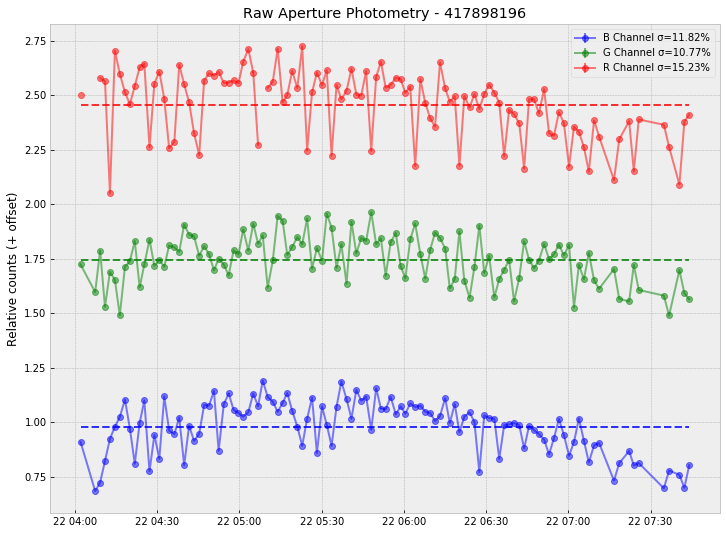

time: 837 ms


In [18]:
plt.figure(figsize=(12, 9))

for i, color in enumerate('bgr'):
    color_data = target_phot.loc[target_phot.channel == color]
    
    clipped_counts = sigma_clip(color_data.counts, sigma=3)

    counts_mean = clipped_counts.mean()
    counts_median = np.median(clipped_counts)
    
    normalizer = counts_median
    
    counts_z = clipped_counts / normalizer
    counts_std = clipped_counts.std() / normalizer
    
    # Add the noise
    color_noise = color_data.noise / normalizer
    
    c_noise = np.ma.array(color_noise, mask=clipped_counts.mask) / normalizer

    offset = i * 0.75
    counts_z += offset
    
    plt.hlines(counts_z.mean(), color_data.index[0], color_data.index[-1], color=color, linestyles='dashed', alpha=0.8)
    plt.errorbar(color_data.index, counts_z, yerr=c_noise, color=color, alpha=0.5, marker='o', ls='-', label=f'{color.upper()} Channel σ={counts_std:.02%}')
    
plt.ylabel('Relative counts (+ offset)')
plt.title(f'Raw Aperture Photometry - {picid}')
plt.legend()
# plt.savefig(os.path.join(base_dir, 'stamps', f'aperture-sums-{picid}.png'), transparent=False, dpi=100)
# plt.savefig(f'aperture-photometry.png', transparent=False, dpi=100)

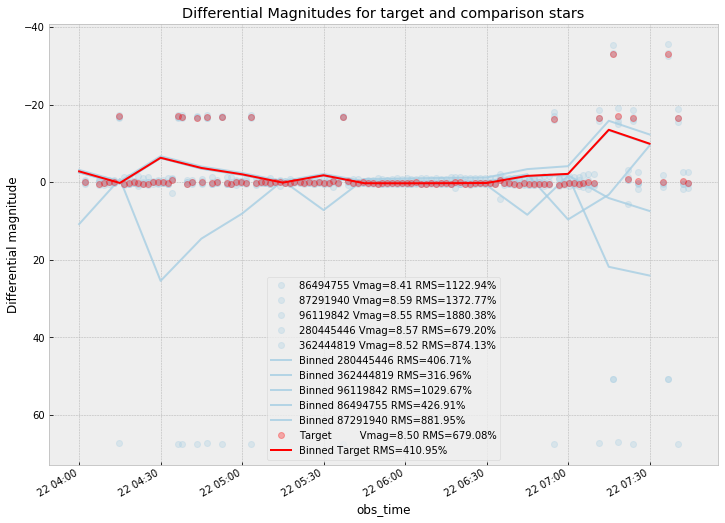

time: 1.03 s


In [19]:
plt.figure(figsize=(12, 9))

# Show each of the comparison stars
for i, info in enumerate(bright_table.groupby('picid')):
    pid = info[0]
    row = info[1]
    c0 = (row.mag_best - comp_star.mag_best)
    c0.plot(label=f'{pid} Vmag={row.iloc[0].vmag:.02f} RMS={c0.std():.02%}', alpha=0.3, marker='o', ls='', **styles['comp_star'])
    
# Binned comparisons
for pid in bright_stars:
    star_table = binned_bright.loc[pid]
    c1 = (star_table.mag_best - binned_comp_star.mag_best)
    c1.plot(label=f'Binned {pid} RMS={c1.std():.02%}', alpha=0.8, **styles['comp_star'])

# Target
t0 = (target_table.mag_best - comp_star.mag_best)
t0.plot(label=f'Target         Vmag={target_table.iloc[0].vmag:.02f} RMS={t0.std():.02%}', alpha=0.3, color='r', marker='o', ls='')    
# # Binned target
t1 = (target_bin.mag_best - binned_comp_star.mag_best)
t1.plot(label=f'Binned Target RMS={t1.std():.02%}', color='r')    
    
plt.gca().invert_yaxis()

plt.ylabel('Differential magnitude')
plt.title('Differential Magnitudes for target and comparison stars')
plt.legend()

##### Normalize

Now we can take the mean-combined comparison star and use it to normalize our target light curve. We do the same for the comparison stars, which we would expect to be flat.

We see that the comparison stars are corrected fairly well but our target still has some variability. In addition to the large dip (which we would hope to be a transit) the light curve has a lot more noise that almost appears periodic. This is the periodic motion of the star (due to the mechanics of the mount) on the RGB pixel pattern. At some points, for example, the centroid of the star's light might be more directly concentrated on a green pixel, at other times a red. Because these colors have different sensitivity responses we see either more or less signal. The data that is binned on time effectively smooths over these differences.

The brighter comparison stars still exhibit some of this pattern but it is less noticable because they are brighter and the light is already spread across more pixels to being with.

## Postage Stamp Cube (PSC)

We can use the positions from the `sources` table to extract a postage stamp for the target for each frame in the observation.

Unlike traditional photometry, which would try to place the centroid of the source directly in the center of the stamp, it is important for our purposes that each frame of the stamp have the same underlying pixel pattern. As a standard we enforce that all stamps have a red pixel in the bottom-left of the stamp provided that the origin (`(0,0)`) is in the bottom-left of the overall frame.

The star's centroid is placed within the center superpixel and a stamp size must have have an odd number of superpixels on each side of the center superpixel. The minimum stamp size is therefore 3x3 superpixels, or 6x6 regular pixels. The next size would be 5x5 superpixels or 10x10 pixels. Generally a stamp shold not need to be larger than 14x14 pixels. The size of the postage stamp will have an effect on the comparison stars that are selected by our algorithm.

A smaller 4-pixel aperture can later be pulled from the original stamp for any final photometric steps.

In [20]:
camera_bias = 2048
stamp_size = 6

time: 654 µs


In [21]:
target_table.head()

,ra,dec,x,y,xpeak_image,ypeak_image,background,flux_best,fluxerr_best,mag_best,...,photnoise_stamp,flux_r,photon_noise_stamp_r,readout_stamp_r,flux_g,photon_noise_stamp_g,readout_stamp_g,flux_b,photon_noise_stamp_b,readout_stamp_b
obs_time,,,,,,,,,,,,,,,,,,,,,
2018-08-22 04:02:02,298.866948,20.275521,3055,1801,3054.9333,1800.8268,3598.571,11912.62,2186.640,14.8100,...,0.009497,8815.0,93.0,63.0,-2803.0,NaN,126.0,5073.0,71.0,63.0
2018-08-22 04:07:23,298.867033,20.276343,3056,1802,3055.4390,1802.1014,3636.088,10779.39,1374.445,14.9185,...,0.010495,7390.0,85.0,63.0,-3471.0,NaN,126.0,5160.0,71.0,63.0
2018-08-22 04:09:11,298.866688,20.276501,3055,1802,3055.1716,1802.2853,3630.643,10481.51,1419.958,14.9489,...,0.010191,-1681.0,NaN,63.0,12723.0,112.0,126.0,-1412.0,NaN,63.0
2018-08-22 04:10:58,298.866848,20.276215,3055,1802,3055.2351,1802.3123,3620.287,10302.07,1550.129,14.9677,...,0.010082,-1687.0,NaN,63.0,12913.0,113.0,126.0,-1388.0,NaN,63.0
2018-08-22 04:12:46,298.866985,20.275532,3055,1801,3054.9478,1800.5416,3514.677,13554.13,1737.392,14.6698,...,0.009081,8285.0,91.0,63.0,-1821.0,NaN,126.0,5662.0,75.0,63.0


time: 36.6 ms


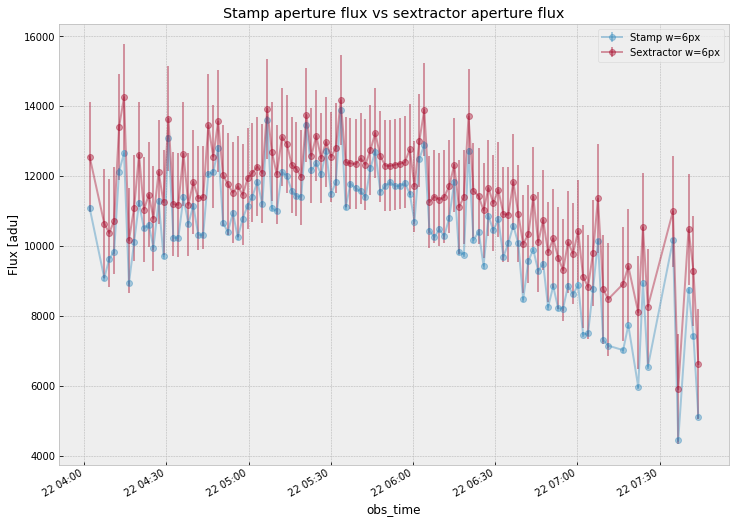

time: 758 ms


In [22]:
plt.figure(figsize=(12, 9))
target_table.flux_stamp.plot(marker='o', yerr=np.sqrt((target_table.flux_stamp / gain.value)), alpha=0.4, label=f'Stamp w={stamp_size}px')

target_table.flux_aper.plot(marker='o', yerr=target_table.fluxerr_aper, alpha=0.4, label='Sextractor w=6px')

plt.title(f'Stamp aperture flux vs sextractor aperture flux')

plt.ylabel('Flux [adu]')

plt.legend()

For the stamp that we have extracted there seems to be a strong time-dependence, with the value alternating between a high and low value.

Since we know that the RGB color array can have significant effects, we can postulate that the source is moving on the detector at these regular time intervals. This can be examined in two ways: looking at the difference in color channels, which will provide inside on how it moves on the detector; and by plotting the RA/Dec pixel drift for the detected centroid.

#### Pixel drift

We wish to see how the target moved across the detector and can get an initial sense of that by looking at how the detected centroid moved:

Text(0.5, 1.0, 'Pixel drift for 417898196')

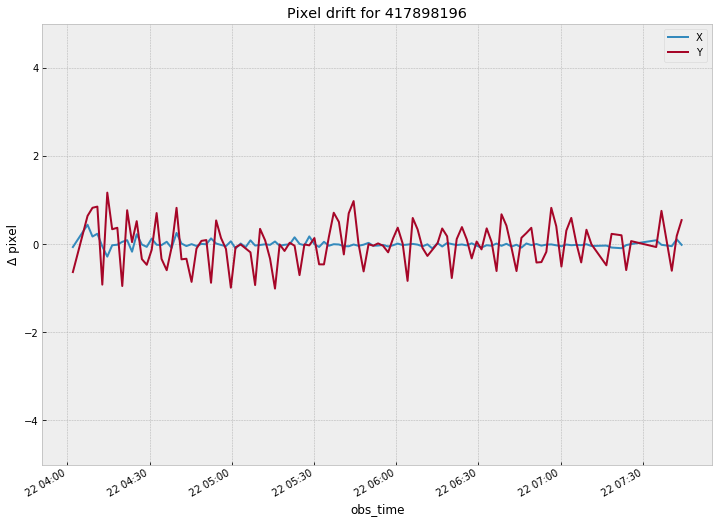

time: 470 ms


In [23]:
plt.figure(figsize=(12, 9))
(target_table.xpeak_image - target_table.xpeak_image.mean()).plot(label='X')
(target_table.ypeak_image - target_table.ypeak_image.mean()).plot(label='Y')

plt.ylim([-5, 5])
plt.ylabel('Δ pixel')
plt.legend()
plt.title(f'Pixel drift for {picid}')

#### Color channel photometry

/home/wtylergee/miniconda3/envs/pipeline/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until
/home/wtylergee/miniconda3/envs/pipeline/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.
/home/wtylergee/miniconda3/envs/pipeline/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """


Text(0.5, 1.0, 'Color channel flux')

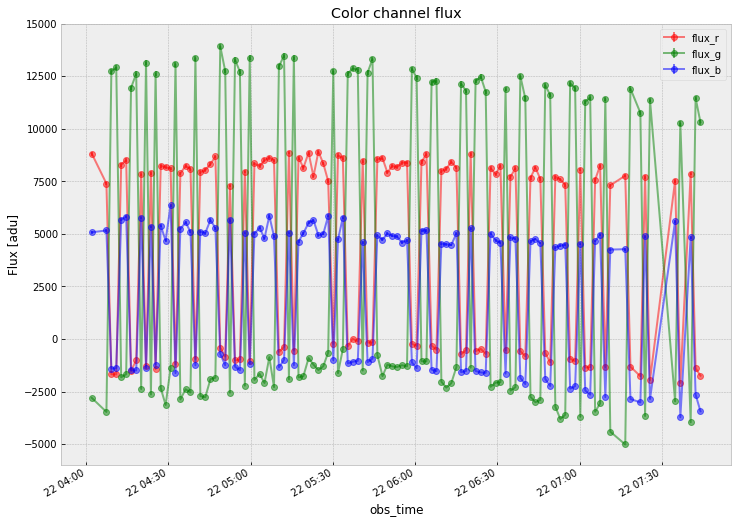

time: 727 ms


In [24]:
plt.figure(figsize=(12, 9))

target_table.flux_r.plot(yerr=np.sqrt(target_table.flux_r), ls='-',marker='o', color='r', alpha=0.5)
target_table.flux_g.plot(yerr=np.sqrt(target_table.flux_g), ls='-',marker='o', color='g', alpha=0.5)
target_table.flux_b.plot(yerr=np.sqrt(target_table.flux_b), ls='-',marker='o', color='b', alpha=0.5)

plt.legend()
plt.ylabel('Flux [adu]')

plt.title('Color channel flux')

So here we can see that most of the variability is coming on the red and blue channels, which is not surprising, but looking closer we can see that they tend to spike in values at opposite times. Likely this is due to the movement of the target across the detector. Depending on the position of the source, a red or blue pixel might be receiving more overall photons and has a different response to those photons.

The goal would not necessarily be to eliminate the differences or the time-dependent spikes, but rather to find comparison stars that exhibit the same overall time-dependency.

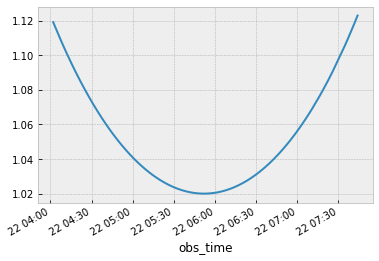

time: 248 ms


In [25]:
target_table.airmass.plot()

In [26]:
target_table.head()

,ra,dec,x,y,xpeak_image,ypeak_image,background,flux_best,fluxerr_best,mag_best,...,photnoise_stamp,flux_r,photon_noise_stamp_r,readout_stamp_r,flux_g,photon_noise_stamp_g,readout_stamp_g,flux_b,photon_noise_stamp_b,readout_stamp_b
obs_time,,,,,,,,,,,,,,,,,,,,,
2018-08-22 04:02:02,298.866948,20.275521,3055,1801,3054.9333,1800.8268,3598.571,11912.62,2186.640,14.8100,...,0.009497,8815.0,93.0,63.0,-2803.0,NaN,126.0,5073.0,71.0,63.0
2018-08-22 04:07:23,298.867033,20.276343,3056,1802,3055.4390,1802.1014,3636.088,10779.39,1374.445,14.9185,...,0.010495,7390.0,85.0,63.0,-3471.0,NaN,126.0,5160.0,71.0,63.0
2018-08-22 04:09:11,298.866688,20.276501,3055,1802,3055.1716,1802.2853,3630.643,10481.51,1419.958,14.9489,...,0.010191,-1681.0,NaN,63.0,12723.0,112.0,126.0,-1412.0,NaN,63.0
2018-08-22 04:10:58,298.866848,20.276215,3055,1802,3055.2351,1802.3123,3620.287,10302.07,1550.129,14.9677,...,0.010082,-1687.0,NaN,63.0,12913.0,113.0,126.0,-1388.0,NaN,63.0
2018-08-22 04:12:46,298.866985,20.275532,3055,1801,3054.9478,1800.5416,3514.677,13554.13,1737.392,14.6698,...,0.009081,8285.0,91.0,63.0,-1821.0,NaN,126.0,5662.0,75.0,63.0


time: 62.9 ms


See [Find Similar Stars](PIAA-Find-Similar-Stars.ipynb)